## Ecuaciones Maestras

Llegamos a las ecuaciones maestras que arman el *algoritmo de retropropagación*
\begin{align}\tag{1}
x_j^{(\ell)} &= \phi\left(\sum_{i=1}^{d^{(\ell-1)}} w_{ij}^{(\ell)} x_i^{(\ell-1)} - b_j^{(\ell)}\right),\quad \ell=1,\dots,L-1\\ \tag{2}
s_j^{(\ell)} &= \sum_{i=1}^{d^{(\ell-1)}} w_{ij}^{(\ell)} x_i^{(\ell-1)} - b_j^{(\ell)}\\ \tag{3}
y_j &= x_j^{(L)} = \sum_{i=1}^{d^{(L-1)}} \lambda_{ij} x_i^{(L-1)}\\ \tag{4}
\delta_j^{(L)} &= \frac{\partial C}{\partial y_j}\\ \tag{5}
\delta_i^{(\ell-1)} &= \phi'(s_i^{(\ell-1)})\sum_{j=1}^{d^{(\ell)}} w_{ij}^{(\ell)} \delta_j^{(\ell)},\quad \text{(fórmula de retropropagación de deltas)}\\ \tag{6}
\partial_{\lambda_{ij}} C &= x_i^{(L-1)}\delta_j^{(L)}\\ \tag{7}
\partial_{w_{ij}^{(\ell)}} C &= x_i^{(\ell-1)} \delta_j^{(\ell)}\\ \tag{8}
\partial_{b_j^{(\ell)}} C &= -\delta_j^{(\ell)}.
\end{align}

Las ecuaciones (1), (2) y (3) son el forward method. Es decir el cálculo de la salida de la red.

Las ecuaciones (4) y (5) son el algoritmo de retropropagación para el cálculo de deltas.

Finalmente, las ecuaciones (6), (7) y (8) son el cálculo del gradiente de la función de costo.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def initialize_parameters(d):
    '''
    inputs:
    d : list of L+1 integers where d[i] is the number of neurons in layer i
        d[0] : number of featuress
        d[L] : number of output neurons
    N : number of samples in the training set

    outputs:
    W : list of L matrices where W[l, i, j] is the weight from input i to the neuron j in the layer l
    B : list of L vectors where B[l, j] is the bias from the neuron j in the layer l
    d_cost_W :
    d_cost_B :

    '''
    L = len(d) - 1
    W = {}
    B = {}
    np.random.seed(0)
    for l in range(1, L+1):
        for j in range(1, d[l]+1):
            # Biases
            B[l, j] = np.random.uniform(low=-0.5, high=0.5)

            # Weights
            for i in range(1, d[l-1]+1):
                W[l, i, j] = np.random.uniform(low=-0.5, high=0.5)
    return W, B

# Test
d_test = [3, 2, 4]
W_test, B_test = initialize_parameters(d_test)
print("Test Case 1:")
print("W:", W_test)
print("B:", B_test)


Test Case 1:
W: {(1, 1, 1): 0.21518936637241948, (1, 2, 1): 0.10276337607164387, (1, 3, 1): 0.044883182996896864, (1, 1, 2): 0.14589411306665612, (1, 2, 2): -0.06241278873730749, (1, 3, 2): 0.39177300078207977, (2, 1, 1): -0.1165584811742223, (2, 2, 1): 0.2917250380826646, (2, 1, 2): 0.06804456109393231, (2, 2, 2): 0.42559663829266103, (2, 1, 3): -0.4128707002984593, (2, 2, 3): -0.4797816025596743, (2, 1, 4): 0.2781567509498505, (2, 2, 4): 0.37001214824681916}
B: {(1, 1): 0.04881350392732475, (1, 2): -0.07634520066109529, (2, 1): 0.4636627605010293, (2, 2): 0.02889491975290448, (2, 3): -0.42896394180211306, (2, 4): 0.332619845547938}


In [3]:
def initialize_gradient(d):
    L = len(d) - 1
    d_cost_W_mean = {}
    d_cost_B_mean = {}

    for l in range(1, L+1):
        for j in range(1, d[l]+1):
            # gradient_W
            d_cost_B_mean[l, j] = 0
        
            # gradient_B
            for i in range(d[l-1]+1):
                d_cost_W_mean[l, i, j] = 0
    return d_cost_W_mean, d_cost_B_mean

In [4]:
def forward_propagation(x_0, W, B, phi, d):  
    if d[0] == 1:
        x_0 = [x_0]

    assert len(x_0) == d[0], "x_0 must have the same number of features as d[0]"
    L = len(d) - 1
    X = {}
    # copy x_0
    for j in range(d[0]):
        X[0, j + 1] = x_0[j]

    # loop layers
    for l in range(1, L + 1):
        for j in range(1, d[l] + 1):
            s = - B[l, j]
            for i in range(1, d[l - 1] + 1):
                s += W[l, i, j] * X[l - 1, i]
            
            # apply activation function
            #X[l, j] = phi(s)
            if l < L:
                X[l,j] = phi(s)
            else:
                X[l,j] = s
    return X

# Define activation function (ReLU)
def relu(x):
    return max(0, x)

# Input vector (x_0): 2 features
x_0 = [1.0, -2.0]

# Network architecture: 2 → 2 → 1
d = [2, 2, 1]  # 2 input, 2 hidden, 1 output

# Weights: W[l, i, j] (from neuron i in layer l-1 to neuron j in layer l)
W = {
    (1, 1, 1): 0.5, (1, 2, 1): -0.3,
    (1, 1, 2): 0.8, (1, 2, 2): 0.1,
    (2, 1, 1): 1.2, (2, 2, 1): -0.7
}

# Biases: B[l, j] (not nested, direct access by layer and neuron)
B = {
    (1, 1): 0.1, (1, 2): -0.2,
    (2, 1): 0.3
}

# Call the function
result = forward_propagation(x_0, W, B, relu, d)

# Print result
for key in sorted(result.keys()):
    print(f"X{key} = {result[key]}")


X(0, 1) = 1.0
X(0, 2) = -2.0
X(1, 1) = 1.0
X(1, 2) = 0.8
X(2, 1) = 0.33999999999999997


In [5]:
def backpropagation(X, y_0, W, B, d_phi, d):
    delta = {}
    L = len(d) - 1
                
    if d[-1] == 1:
        y_0 = [y_0]

    for j in range(1, d[L] + 1):
        # 6.2.25
        #s = - B[L, j] # (s_j)^L
        #for i in range(1, d[L - 1] + 1):
        #    s += W[L, i, j] * X[L - 1, i]
        #delta[L, j] = (X[L, j] - y_0[j-1]) * d_phi(s) # squared error
        delta[L, j] = (X[L,j] - y_0[j-1])

    for l in range(L-1, 0, -1):
        for i in range(1, d[l] + 1):
            # 6.2.26
            s1 = - B[l, i] # (s_i)^{l-1}
            for j in range(1, d[l - 1] + 1):
                s1 += W[l, j, i] * X[l - 1, j]

            s2 = 0
            for j in range(1, d[l+1] + 1):
                s2 += W[l + 1, i, j] * delta[l + 1, j]

            #delta[l, i] = d_phi(s1) * s2
            if l < L:
                delta[l, i] = d_phi(s1) * s2
            else:
                delta[l, i] = s2
    return delta

def d_relu(x):
    return 1.0 if x > 0 else 0.0

# ---------- Test Case 2: simple 2-2-1 network with ReLU ----------
d2 = [2, 2, 1]
X2 = {(0,1):1.0,(0,2):-2.0,(1,1):0.0,(1,2):2.0,(2,1):2.0}
y2 = 1
W2 = {
    (1,1,1):1.0,(1,2,1):1.0,(1,1,2):2.0,(1,2,2):0.0,
    (2,1,1):1.0,(2,2,1):1.0
}
B2 = {(1,1):0.0,(1,2):0.0,(2,1):0.0}
e2 = {(2,1):1.0,(1,1):0.0,(1,2):1.0}
r2 = backpropagation(X2, y2, W2, B2, d_relu, d2)
assert math.isclose(r2[(2,1)], e2[(2,1)], abs_tol=1e-9)
assert math.isclose(r2[(1,1)], e2[(1,1)], abs_tol=1e-9)
assert math.isclose(r2[(1,2)], e2[(1,2)], abs_tol=1e-9)
print("Passed, deltas=", r2)


Passed, deltas= {(2, 1): 1.0, (1, 1): 0.0, (1, 2): 1.0}


In [6]:
from sklearn.metrics import mean_squared_error
def testing(X_test: np.ndarray, y_test: np.ndarray, W: dict, B: dict, d: list, phi) -> float:
    assert len(X_test) == len(y_test)
    y_pred = []
    for x in X_test:
        X = forward_propagation(x, W, B, phi, d)
        y_pred.append([X[len(d)-1, j] for j in range(1, d[-1] + 1)])
    y_pred = np.array(y_pred)
    return y_pred, mean_squared_error(y_pred, y_test)

In [7]:
def fit_neural_network_regression(X_train: np.ndarray, y_train: np.ndarray,
                              d: list, nabla: float, phi, d_phi, max_iter=10, eps=1e-3) -> {dict, dict}:
    '''
    inputs:

    d : list of L+1 integers where d[i] is the number of neurons in layer i
        d[0] : number of featuress
        d[L] : number of output neurons
    X_train: training data with shape (n_samples, d[0])
    y_train: training labels with shape (n_samples, d[L])

    nabla : learning rate > 0
    phi : activation function to apply to the output layer
        e.g. sigmoid, relu, softmax, etc.

    d_phi : derivative of the activation function

    outputs:
    W : dict where W[l, i, j] is the weight from input i to the neuron j in the layer l
    B : dict where B[l, j] is the bias from the neuron j in the layer l
    '''
    N = len(X_train)
    W, B = initialize_parameters(d)
    L = len(d) - 1

    # loop epocas:
    n = 0
    grad_norm = 1
    while n < max_iter and grad_norm > eps:
        grad_norm = 0
        # initialize gradients
        d_cost_W_mean, d_cost_B_mean = initialize_gradient(d)

        # batch training
        for k in range(N):
            x_0 = X_train[k]
            y_0 = y_train[k]

            X = forward_propagation(x_0, W, B, phi, d)
            delta = backpropagation(X, y_0, W, B, d_phi, d)

            # acumulate gradients 
            for l in range(1, L+1):
                for j in range(1, d[l]+1):
                    # gradient_W
                    d_cost_B_mean[l, j] += delta[l, j]

                    # gradient_B
                    for i in range(1, d[l-1]+1):
                        d_cost_W_mean[l, i, j] += delta[l, j] * X[l-1, i]

        # take the mean of the gradients and apply the gradient descent algorithm, and gradient norm
        grad_norm = 0.0
        for l in range(1, L+1):
            for j in range(1, d[l]+1):
                # gradient_B
                d_cost_B_mean[l, j] /= N
                B[l, j] -= nabla * d_cost_B_mean[l, j]
                grad_norm += (d_cost_B_mean[l, j])**2

                for i in range(1, d[l-1]+1):
                    # gradient_W
                    d_cost_W_mean[l, i, j] /= N
                    W[l, i, j] -= nabla * d_cost_W_mean[l, i, j]
                    grad_norm += (d_cost_W_mean[l, i, j])**2
        
        grad_norm = np.sqrt(grad_norm)
        n += 1

    _, score = testing(X_train, y_train, W, B, d, phi)
    print(f'MSE with the train data: {score}')
    return W, B

## 1D test

In [8]:
def tanh(x: np.ndarray) -> np.ndarray:
    """Hyperbolic tangent function."""
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def d_tanh(x: np.ndarray) -> np.ndarray:
    """Derivative of the hyperbolic tangent function."""
    t = tanh(x)
    return 1 - t**2

MSE with the train data: 0.5098511622328284


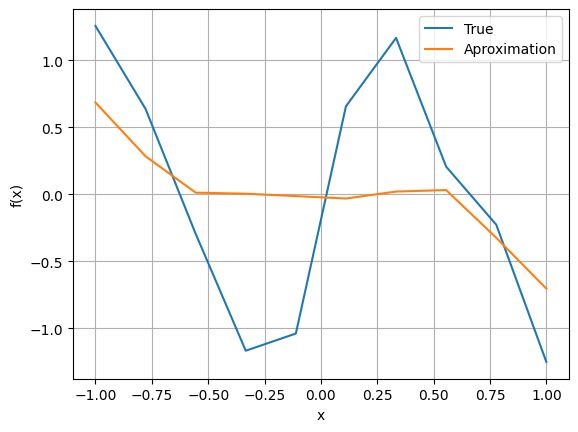

In [9]:
# the test set is our eyes

X_train = np.linspace(-1, 1, 10)
#y_train = (np.sin(1 / (0.1 + (X_train - 2.5)**2)) * np.exp(-(X_train - 2.5)**2))
y_train = np.sin(X_train*5) + np.random.normal(0, 0.2, len(X_train))

d = [1, 100, 100, 1]
nabla = 0.001

W, B = fit_neural_network_regression(X_train, y_train, d, nabla, relu, d_relu, max_iter=2000, eps=0.001)

y_pred, score = testing(X_train, y_train, W, B, d, relu)

# the test set is our eyes

plt.plot(X_train, y_train, label='True')
plt.plot(X_train, y_pred, label='Aproximation')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

MSE with the train data: 0.00409880207538034


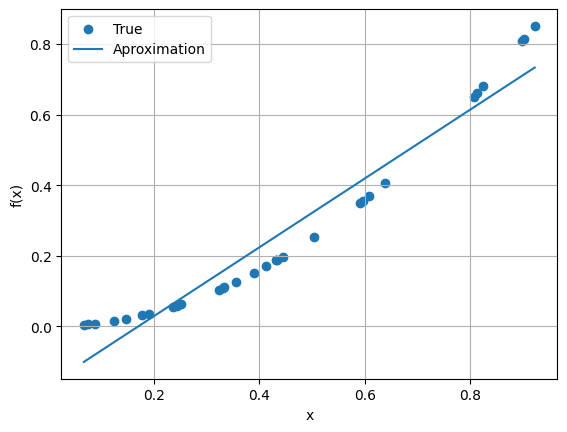

In [11]:
# Linear regression
def identity(x):
    return x

def d_identity(x):
    return 1

# the test set is our eyes
np.random.seed()
X_train = np.sort(np.random.uniform(0, 1, 30))
y_train = X_train**2 # it is nearly linear

d = [1, 1, 1]
nabla = 0.01

W, B = fit_neural_network_regression(X_train, y_train, d, nabla, identity, d_identity, max_iter=1000, eps=0.001)

y_pred, score = testing(X_train, y_train, W, B, d, identity)

# the test set is our eyes

plt.scatter(X_train, y_train, label='True')
plt.plot(X_train, y_pred, label='Aproximation')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

## Forma matricial de las ecuaciones maestras

Para la implementación es mejor escribir las ecuaciones (1)--(8) en forma matricial que es como trabaja el código.
Los datos entonces se toman
$$
\mathbf x^{(\ell)} = (x_1^{(\ell)},\dots,x_{d^{(\ell)}}^{(\ell)})^T,\ W^{(\ell)} = (w_{ij}^{(\ell)})_{i,j},\ \mathbf b^{(\ell)} = (b_1^{(\ell)},\dots,b_{d^{(\ell)}}^{(\ell)})^T
$$
$$
\delta^{(\ell)} = (\delta_1^{(\ell)},\dots,\delta_{d^{(\ell)}}^{(\ell)})^T,\ \mathbf s^{(\ell)} = (s_1^{(\ell)},\dots,s_{d^{(\ell)}}^{(\ell)})^T
$$
con la convención de que aplicar la función de activación $\phi$ sobre un vector es hacerlo componente a componente. Entonces las ecuaciones quedan
\begin{align}
\mathbf x^{(\ell)} &= \phi\left(W^{(\ell)^T} \mathbf x^{(\ell-1)} - \mathbf b^{(\ell)}\right)\\
\delta^{(L)} &= \nabla_{\mathbf y}C(\mathbf x^{(L)}, \mathbf z) \odot \phi'(\mathbf s^{(L)})\\
\delta^{(\ell-1)} &= (W^{(\ell)}\delta^{(\ell)})\odot \phi'(\mathbf s^{(\ell-1)})\\
\frac{\partial C}{\partial W^{(\ell)}} &= \mathbf x^{(\ell-1)} \delta^{(\ell)^T}\\
\frac{\partial C}{\partial \mathbf b^{(\ell)}} &= -\delta^{(\ell)},
\end{align}
donde $\odot$ es el producto de Hadamard entre vectores que consiste en multiplicar componente a componente.